<a href="https://colab.research.google.com/github/kdh4672/economy_ai/blob/main/EC5320_2022_1_Week4b_CNN_regression_age_prediction_SIMPLIFIED_v1_FOR_TEACHING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EC5320 Week4a codes: CNN regression (Age detection)

2022.3.28.<br>

Author: Hyunjoo Yang (hyang@sogang.ac.kr)<br><br>

This notebook uses CNN to do age prediction.<br><br>

Data source for face images: <br>
https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/ <br><br>

Codes are based on: <br>
https://medium.com/analytics-vidhya/fastai-image-regression-age-prediction-based-on-image-68294d34f2ed <br><br>

For image augmentation, refer to: <br>
https://github.com/fastai/fastbook/blob/master/02_production.ipynb <br><br>

For AI and ethics, refer to: <br>
https://github.com/fastai/fastbook/blob/master/03_ethics.ipynb <br><br>

# 1. Install and import libraries

In [1]:
# upgrade fastai to the most recent version (v. 2.5.3)

%%capture
!pip install fastai --upgrade

In [2]:
import fastai
print(fastai.__version__)

from fastai.vision.all import *
#from fastai.text.all import *
#from fastai.collab import *
#from fastai.tabular.all import * 

from matplotlib.pyplot import imshow

2.5.6


In [3]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import imshow
from google.colab import files

# 2. Download file

In [4]:
!wget -O imdb_crop_sample.zip 'https://www.dropbox.com/s/alphyo3ofqsy5ff/imdb_crop_sample.zip?dl=0'

--2022-04-24 09:55:11--  https://www.dropbox.com/s/alphyo3ofqsy5ff/imdb_crop_sample.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.67.18, 2620:100:6023:18::a27d:4312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.67.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/alphyo3ofqsy5ff/imdb_crop_sample.zip [following]
--2022-04-24 09:55:11--  https://www.dropbox.com/s/raw/alphyo3ofqsy5ff/imdb_crop_sample.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3a65b9828a75a23e5281e0a53a.dl.dropboxusercontent.com/cd/0/inline/Bj_yW4n56O82TlYw5Y-fxYD18qRzdmrSN_kWmYwanBdOB79WN87oMG6aqp7fil_8IrnCJusayZ-F_I_agLyh4WSOUF2pIe6Z53iLywwVL8GD1kANgjLdP0g_ULKRIjJaa9aYlqPkCbwyyEfkFIcJV-x45u-s8SlaIddL-li4Zp28cQ/file# [following]
--2022-04-24 09:55:11--  https://uc3a65b9828a75a23e5281e0a53a.dl.dropboxusercontent.com/cd/0/inline/Bj_yW4n56O82TlYw5Y-fxYD18qRzdmrSN_kW

In [5]:
%%capture

!unzip imdb_crop_sample.zip -d faces

In [6]:
!ls

faces  imdb_crop_sample.zip  sample_data


# 3. Prepare image file path + label dataframe

## 3.1 grab image file paths

In [7]:
# *** CHANGE directory and file extension HERE ***

where_and_what_to_search = 'faces/*.jpg' # YOUR IMAGE SUBFOLDER / IMAGE FILE EXTENSION

# grab image file paths

import glob
img_full_path = pd.Series(glob.glob(where_and_what_to_search), name='my_file_path')
img_nm = pd.Series(img_full_path.str.split(pat="/").str[1], name='file_nm')

df_imdb_sample = pd.concat([img_full_path, img_nm], axis=1)
df_imdb_sample

,my_file_path,file_nm
0,faces/nm0177896_rm1769392128_1975-1-5_2001.jpg,nm0177896_rm1769392128_1975-1-5_2001.jpg
1,faces/nm0061262_rm607623168_1963-3-1_2007.jpg,nm0061262_rm607623168_1963-3-1_2007.jpg
2,faces/nm1561547_rm2537921024_1974-8-22_2006.jpg,nm1561547_rm2537921024_1974-8-22_2006.jpg
3,faces/nm0005499_rm1765657600_1939-9-1_1980.jpg,nm0005499_rm1765657600_1939-9-1_1980.jpg
4,faces/nm0683253_rm1392952320_1979-1-27_2014.jpg,nm0683253_rm1392952320_1979-1-27_2014.jpg
...,...,...
4995,faces/nm2301950_rm3091175424_1994-4-11_2007.jpg,nm2301950_rm3091175424_1994-4-11_2007.jpg
4996,faces/nm0005363_rm2532425472_1968-9-10_2011.jpg,nm0005363_rm2532425472_1968-9-10_2011.jpg
4997,faces/nm0521753_rm3685718784_1964-7-28_2006.jpg,nm0521753_rm3685718784_1964-7-28_2006.jpg
4998,faces/nm0000538_rm2770832896_1953-5-30_1992.jpg,nm0000538_rm2770832896_1953-5-30_1992.jpg


## 3.2 Extract the year of photo taken & year of birth from file names

In [8]:
# extract the year when the photo was taken from file names from 'file_nm'

df_imdb_sample['photo_taken'] = df_imdb_sample.file_nm.str.extract(r'[\_](\d\d\d\d)[\.][j][p][g]$')

In [9]:
# extract year of birth from 'file_nm'

df_imdb_sample['year_of_birth'] = df_imdb_sample.file_nm.str.extract(r'[\_](\d\d\d\d)[-]')

In [10]:
df_imdb_sample

,my_file_path,file_nm,photo_taken,year_of_birth
0,faces/nm0177896_rm1769392128_1975-1-5_2001.jpg,nm0177896_rm1769392128_1975-1-5_2001.jpg,2001,1975
1,faces/nm0061262_rm607623168_1963-3-1_2007.jpg,nm0061262_rm607623168_1963-3-1_2007.jpg,2007,1963
2,faces/nm1561547_rm2537921024_1974-8-22_2006.jpg,nm1561547_rm2537921024_1974-8-22_2006.jpg,2006,1974
3,faces/nm0005499_rm1765657600_1939-9-1_1980.jpg,nm0005499_rm1765657600_1939-9-1_1980.jpg,1980,1939
4,faces/nm0683253_rm1392952320_1979-1-27_2014.jpg,nm0683253_rm1392952320_1979-1-27_2014.jpg,2014,1979
...,...,...,...,...
4995,faces/nm2301950_rm3091175424_1994-4-11_2007.jpg,nm2301950_rm3091175424_1994-4-11_2007.jpg,2007,1994
4996,faces/nm0005363_rm2532425472_1968-9-10_2011.jpg,nm0005363_rm2532425472_1968-9-10_2011.jpg,2011,1968
4997,faces/nm0521753_rm3685718784_1964-7-28_2006.jpg,nm0521753_rm3685718784_1964-7-28_2006.jpg,2006,1964
4998,faces/nm0000538_rm2770832896_1953-5-30_1992.jpg,nm0000538_rm2770832896_1953-5-30_1992.jpg,1992,1953


In [11]:
df_imdb = df_imdb_sample

## 3.3 Check missing labels

In [12]:
# check if missing variable
df_imdb.isnull().sum()

my_file_path     0
file_nm          0
photo_taken      0
year_of_birth    1
dtype: int64

In [13]:
# delete NaN sample
df_imdb = df_imdb.replace([np.inf, -np.inf], np.nan)
df_imdb.dropna(inplace=True)

In [14]:
# check if missing variable
df_imdb.isnull().sum()

my_file_path     0
file_nm          0
photo_taken      0
year_of_birth    0
dtype: int64

In [15]:
df_imdb.shape

(4999, 4)

## 3.4 Calculate age

In [16]:
df_imdb.dtypes

my_file_path     object
file_nm          object
photo_taken      object
year_of_birth    object
dtype: object

In [17]:
# convert columns related to years to int64 dtype
df_imdb = df_imdb.astype({"photo_taken": int, "year_of_birth": int})

In [18]:
df_imdb.dtypes

my_file_path     object
file_nm          object
photo_taken       int64
year_of_birth     int64
dtype: object

In [19]:
# calculate age
df_imdb['age'] = df_imdb['photo_taken'] - df_imdb['year_of_birth']

# some guys seem to be greater than 100. some of these are paintings. remove these old guys
df_imdb = df_imdb[df_imdb['age'] <= 100]

# some guys seem to be unborn in the data set
df_imdb = df_imdb[df_imdb['age'] > 0]

In [20]:
df_imdb.shape

(4994, 5)

In [21]:
df_imdb

,my_file_path,file_nm,photo_taken,year_of_birth,age
0,faces/nm0177896_rm1769392128_1975-1-5_2001.jpg,nm0177896_rm1769392128_1975-1-5_2001.jpg,2001,1975,26
1,faces/nm0061262_rm607623168_1963-3-1_2007.jpg,nm0061262_rm607623168_1963-3-1_2007.jpg,2007,1963,44
2,faces/nm1561547_rm2537921024_1974-8-22_2006.jpg,nm1561547_rm2537921024_1974-8-22_2006.jpg,2006,1974,32
3,faces/nm0005499_rm1765657600_1939-9-1_1980.jpg,nm0005499_rm1765657600_1939-9-1_1980.jpg,1980,1939,41
4,faces/nm0683253_rm1392952320_1979-1-27_2014.jpg,nm0683253_rm1392952320_1979-1-27_2014.jpg,2014,1979,35
...,...,...,...,...,...
4995,faces/nm2301950_rm3091175424_1994-4-11_2007.jpg,nm2301950_rm3091175424_1994-4-11_2007.jpg,2007,1994,13
4996,faces/nm0005363_rm2532425472_1968-9-10_2011.jpg,nm0005363_rm2532425472_1968-9-10_2011.jpg,2011,1968,43
4997,faces/nm0521753_rm3685718784_1964-7-28_2006.jpg,nm0521753_rm3685718784_1964-7-28_2006.jpg,2006,1964,42
4998,faces/nm0000538_rm2770832896_1953-5-30_1992.jpg,nm0000538_rm2770832896_1953-5-30_1992.jpg,1992,1953,39


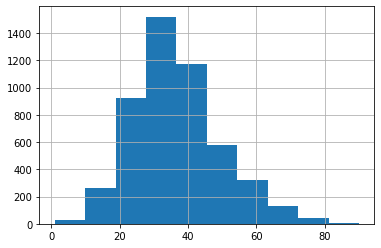

In [22]:
df_imdb['age'].hist()

# 4. Prepare data for CNN

In [23]:
# data block settings

my_random_seed = 42
my_batch_size = 64

In [24]:
from fastai.vision.data import ImageDataLoaders

In [25]:
df_imdb_simple = df_imdb[['my_file_path','age']]
df_imdb_simple

,my_file_path,age
0,faces/nm0177896_rm1769392128_1975-1-5_2001.jpg,26
1,faces/nm0061262_rm607623168_1963-3-1_2007.jpg,44
2,faces/nm1561547_rm2537921024_1974-8-22_2006.jpg,32
3,faces/nm0005499_rm1765657600_1939-9-1_1980.jpg,41
4,faces/nm0683253_rm1392952320_1979-1-27_2014.jpg,35
...,...,...
4995,faces/nm2301950_rm3091175424_1994-4-11_2007.jpg,13
4996,faces/nm0005363_rm2532425472_1968-9-10_2011.jpg,43
4997,faces/nm0521753_rm3685718784_1964-7-28_2006.jpg,42
4998,faces/nm0000538_rm2770832896_1953-5-30_1992.jpg,39


In [26]:
dls = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader('my_file_path'), 
    get_y=ColReader('age'),
    splitter=RandomSplitter(valid_pct=0.2, seed=my_random_seed),
    item_tfms=Resize(128)
).dataloaders(df_imdb_simple)

In [27]:
len(dls.train_ds), len(dls.valid_ds)

(3996, 998)

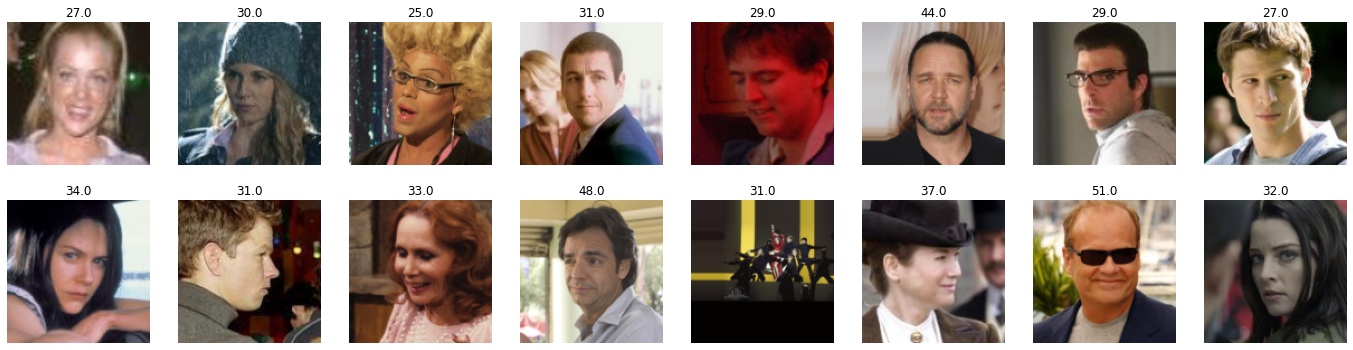

In [28]:
# show image examples

dls.show_batch(max_n=16, nrows=2)

# 5. Train CNN model

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=rmse).to_fp16() # resnet 18, 34, 50, 101, 152
learn.fine_tune(15)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,_rmse,time
0,1453.430420,1349.349854,36.733498,00:33


epoch,train_loss,valid_loss,_rmse,time
0,1339.945679,1306.500732,36.145550,00:28


In [ ]:
learn.show_results()

# 6. Test using your own image

In [ ]:
from google.colab import files

In [ ]:
# upload an image file

uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file: {name}'.format(name=fn))

In [ ]:
# get the file name of the uploaded file 

img_name = list(uploaded.keys())[0]

In [ ]:
# predict

img = PILImage.create(uploaded[img_name])

img.show()

In [ ]:
learn.predict(img)

# 7. Image augmentation

## 7.1 Random Resized Crop

In [ ]:
dls_aug = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader('my_file_path'), 
    get_y=ColReader('age'),
    splitter=RandomSplitter(valid_pct=0.2, seed=my_random_seed),
    item_tfms=RandomResizedCrop(128, min_scale=0.7)
).dataloaders(df_imdb_simple)

In [ ]:
dls_aug.train.show_batch(max_n=8, nrows=2, unique=True)

In [ ]:
learn = cnn_learner(dls_aug, resnet34, metrics=rmse).to_fp16() # resnet 18, 34, 50, 101, 152
learn.fine_tune(15)

epoch,train_loss,valid_loss,_rmse,time
0,1447.911865,1360.947021,36.891014,00:17


epoch,train_loss,valid_loss,_rmse,time
0,1329.417603,1336.523315,36.558495,00:17
1,1270.119263,1233.095215,35.115456,00:18
2,1123.801025,930.988831,30.512110,00:17
3,843.098938,593.944946,24.370985,00:17
4,492.285248,346.478119,18.613922,00:17
5,252.357712,205.529678,14.336307,00:17
6,146.849014,190.226562,13.792265,00:18
7,102.221825,177.135941,13.309242,00:17
8,82.157623,177.230087,13.312779,00:18
9,72.698410,161.538467,12.709778,00:18


## 7.2 aug_transforms

In [ ]:
dls_aug2 = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader('my_file_path'), 
    get_y=ColReader('age'),
    splitter=RandomSplitter(valid_pct=0.2, seed=my_random_seed),
    item_tfms=Resize(128),
    batch_tfms=aug_transforms(mult=2)
).dataloaders(df_imdb_simple)

In [ ]:
dls_aug2.train.show_batch(max_n=8, nrows=2, unique=True)

In [ ]:
learn = cnn_learner(dls_aug2, resnet34, metrics=rmse).to_fp16() # resnet 18, 34, 50, 101, 152
learn.fine_tune(15)

epoch,train_loss,valid_loss,_rmse,time
0,1452.182251,1366.078491,36.960499,00:20


epoch,train_loss,valid_loss,_rmse,time
0,1351.442383,1319.506470,36.325012,00:20
1,1294.239136,1207.119019,34.743622,00:21
2,1148.269043,1000.420715,31.629429,00:20
3,881.188354,583.118042,24.147837,00:19
4,537.728943,252.294693,15.883786,00:19
5,303.904419,174.912781,13.225460,00:19
6,205.037445,165.837921,12.877808,00:19
7,170.591446,171.944092,13.112745,00:19
8,153.968018,149.885757,12.242785,00:19
9,142.428009,151.383057,12.303782,00:19


# 8. Early stopping

In [ ]:
learn.validate()

(#2) [143.57659912109375,11.982345581054688]

In [ ]:
learn = cnn_learner(dls_aug2, resnet34, metrics=rmse).to_fp16() # resnet 18, 34, 50, 101, 152
learn.path = Path('./')
learn.fine_tune(50, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3),SaveModelCallback(monitor='valid_loss')])

epoch,train_loss,valid_loss,_rmse,time
0,1460.756348,1335.430908,36.543549,00:19


Better model found at epoch 0 with valid_loss value: 1335.430908203125.


epoch,train_loss,valid_loss,_rmse,time
0,1348.744507,1291.030273,35.930912,00:19
1,1303.973022,1238.786621,35.196400,00:19
2,1246.260254,1173.723389,34.259647,00:19
3,1173.344238,1041.306519,32.269279,00:19
4,1071.613281,927.936462,30.462051,00:19
5,920.773987,758.042542,27.532572,00:19
6,733.445374,572.939514,23.936152,00:19
7,528.472717,385.464569,19.633249,00:19
8,341.688721,208.028748,14.423201,00:19
9,230.514145,170.820572,13.069836,00:19


Better model found at epoch 0 with valid_loss value: 1291.0302734375.
Better model found at epoch 1 with valid_loss value: 1238.78662109375.
Better model found at epoch 2 with valid_loss value: 1173.723388671875.
Better model found at epoch 3 with valid_loss value: 1041.3065185546875.
Better model found at epoch 4 with valid_loss value: 927.9364624023438.
Better model found at epoch 5 with valid_loss value: 758.0425415039062.
Better model found at epoch 6 with valid_loss value: 572.9395141601562.
Better model found at epoch 7 with valid_loss value: 385.4645690917969.
Better model found at epoch 8 with valid_loss value: 208.02874755859375.
Better model found at epoch 9 with valid_loss value: 170.82057189941406.
Better model found at epoch 10 with valid_loss value: 165.71865844726562.
Better model found at epoch 13 with valid_loss value: 160.04522705078125.
No improvement since epoch 13: early stopping


In [ ]:
learn.validate()

(#2) [160.04522705078125,12.650897979736328]